# Basic Neural Network using iris dataset - csatrio

### Parameter setting

In [1]:
import os
model_name = 'iris_model'
output_directory = f'{model_name}_assets'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
o = lambda x : os.path.join(os.getcwd(), output_directory, x)
visualization_name = o(f'{model_name}_torchviz')
visualization_format = 'png'
output_model_name = o(f'{model_name}.pt')

### Create model class that inherits nn.module

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    # in_features = number of columns in the input tensor (how many features are there in the input tensor)
    # out_features = number of columns in the output tensor (how many distinct classes are there)
    # h1 = number of neurons in the first hidden layer
    # h2 = number of neurons in the second hidden layer
    def __init__(self, in_features=4, out_features=3, h1=8, h2=9):
        super(Model, self).__init__() # call the parent class constructor
        self.fc1 = nn.Linear(in_features, h1) # create the first fully connected hidden layer
        self.fc2 = nn.Linear(h1, h2) # create the second fully connected hidden layer
        self.out = nn.Linear(h2, out_features) # create the output layer

    # forward is the method that is called when you pass data to the model
    # relu (rectified linear unit) is the activation function used in the hidden layers
    # in relu, values less than zero are replaced by zero, while value greater than zero remain the same
    # the forward method will move data through the model and return the output
    def forward(self, x):
        x = F.relu(self.fc1(x)) # move data through the first hidden layer and apply the activation function
        x = F.relu(self.fc2(x)) # move data through the second hidden layer and apply the activation function
        x = self.out(x) # move data through the output layer
        return x

In [3]:
torch.manual_seed(32) # set the random seed for reproducibility
model = Model() # create an instance of the model
model.parameters # print the model parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
url = 'https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv'
my_df = pd.read_csv(url)
my_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [6]:
unique_species = my_df['species'].unique() # check for unique species values in the dataset
unique_species

array(['setosa', 'versicolor', 'virginica'], dtype=object)

### Function to change label into number for improving training efficiency

In [7]:
# It's basically a poor man's encoder that maps the species to a number
mapping = {}
for i in range(len(unique_species)):
    mapping[unique_species[i]] = i

def label_to_number(input):
    input_type = type(input)
    # if already a number, leave it unchanged
    if input_type == int or input_type == float or input_type == complex or input_type == torch.Tensor:
        return input
    else: # if a string, convert to number
        return mapping[input]


In [8]:
my_df['species'] = my_df['species'].apply(label_to_number)
my_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### Convert to x and y and to numpy arrays 

In [9]:
X = my_df.drop('species', axis=1).values # get the input features
y = my_df['species'].values # get the target labels

## Create Train / Test Split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [11]:
# This part will convert the input features and target labels to tensors
X_train = torch.FloatTensor(X_train) # convert the input features to a tensor
X_test = torch.FloatTensor(X_test) # convert the input features to a tensor (for testing)
y_train = torch.FloatTensor(y_train) # convert the target labels to a tensor
y_test = torch.FloatTensor(y_test) # convert the target labels to a tensor (for testing)

In [12]:
# Set the criterion of model to measure the error, how far off the model is from the target
criterion = nn.CrossEntropyLoss() # use cross entropy loss for classification problems

# Choose Optimizer
# lr = learning rate, the size of the step the optimizer will take to update the model's weights
# if error is not decreasing, or fluctuating try a smaller learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use the Adam optimizer to update the model's weights

### Train Model

In [13]:
epochs = 10000 # number of times the model will see the entire dataset
losses = [] # store the loss values
print_every_n = 0.1 * epochs # print the loss every n epochs

for i in range(epochs):
    y_pred = model.forward(X_train) # get predicted values
    loss = criterion(y_pred, y_train.long()) # calculate the loss
    losses.append(loss.detach().numpy()) # store the loss, detach() removes the loss from the computational graph
    optimizer.zero_grad() # set the gradients to zero
    loss.backward() # backpropagate the loss, take the error rate of forward propagation and feed it back to the model
    optimizer.step() # update the model's weights
    if i % print_every_n == 0:
        print(f'Epoch: {i} Loss: {loss}')
    
print(f'Epoch: {i + 1} Loss: {loss}')

Epoch: 0 Loss: 1.169895887374878
Epoch: 1000 Loss: 0.06141107156872749
Epoch: 2000 Loss: 0.04901633411645889
Epoch: 3000 Loss: 0.04522395506501198
Epoch: 4000 Loss: 0.04477681964635849
Epoch: 5000 Loss: 0.044738106429576874
Epoch: 6000 Loss: 0.04472952336072922
Epoch: 7000 Loss: 0.04472138360142708
Epoch: 8000 Loss: 0.04471846669912338
Epoch: 9000 Loss: 0.044716719537973404
Epoch: 10000 Loss: 0.04471554979681969


Text(0.5, 0, 'epoch')

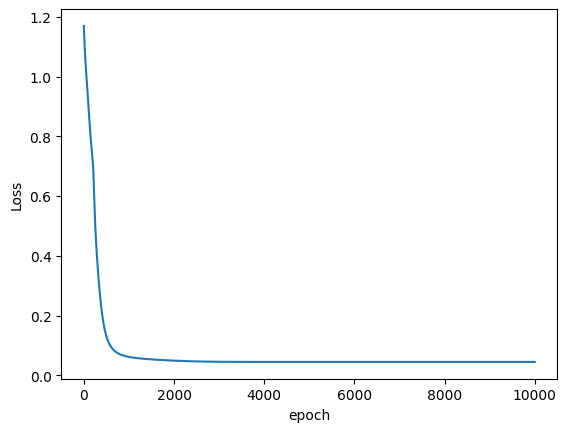

In [14]:
# Graph our losses
plt.plot(range(epochs), losses) # plot the loss values
plt.ylabel('Loss') # label the y-axis
plt.xlabel('epoch') # label the x-axis

### Evaluate model using test data set, Loss on evaluation run should be close to the loss evaluated from training run

In [15]:
# Evaluate Model on Test Data Set (validate model on test set)
with torch.no_grad(): # turn off gradient tracking (back propagation) for validation
    y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
    loss = criterion(y_eval, y_test.long()) # calculate the loss
    print(f'Loss: {loss}')

Loss: 0.023329349234700203


In [16]:
# Evaluate model correctness
correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)

        # Will tell us what type of flow class our network think it is
        print(f'{i+1}. {str(y_val)} {y_test[i]}')

        # Correct or not
        if y_val.argmax().item() == y_test[i]:
            correct += 1
        else :
            print(f'Incorrect: {y_val.argmax().item()} != {y_test[i]}')

print(f'{correct} out of {len(y_test)} = {100*correct/len(y_test)}% correct')

1. tensor([-5.9588, 11.2200,  2.5559]) 1.0
2. tensor([ 12.5032,  -2.5106, -15.1526]) 0.0
3. tensor([ 10.9039,  -1.8266, -13.3829]) 0.0
4. tensor([-6.8558, 10.3951,  3.8116]) 1.0
5. tensor([-12.8315,   7.7980,  11.2205]) 2.0
6. tensor([-15.5441,   6.1930,  14.7251]) 2.0
7. tensor([  9.7853,  -0.6873, -12.3981]) 0.0
8. tensor([ 11.5337,  -2.3133, -13.9769]) 0.0
9. tensor([-5.5615, 10.6524,  2.3101]) 1.0
10. tensor([ 11.7974,  -2.3670, -14.2967]) 0.0
11. tensor([-7.7675, 11.4011,  4.4713]) 1.0
12. tensor([-15.3908,   4.3687,  15.1519]) 2.0
13. tensor([-2.9147, 11.8593, -1.1534]) 1.0
14. tensor([-2.6121, 12.4105, -1.6799]) 1.0
15. tensor([-13.4709,   6.3802,  12.3823]) 2.0
16. tensor([-14.2928,   5.2797,  13.5932]) 2.0
17. tensor([-6.6428, 10.1114,  3.6730]) 1.0
18. tensor([-11.8322,   7.7504,  10.1311]) 2.0
19. tensor([-3.0784, 12.5743, -1.1637]) 1.0
20. tensor([ 12.5421,  -2.5185, -15.1998]) 0.0
21. tensor([ 11.1438,  -1.8796, -13.6380]) 0.0
22. tensor([-17.5528,   5.5557,  17.1316]) 2.0

In [17]:
# Save the model
torch.save(model.state_dict(), output_model_name)

### Visualize the neural network

In [18]:
from torchviz import make_dot

# create some sample input data
x = X_test[0]

# generate predictions for the sample data
y = model(x)

# generate a model architecture visualization
z = make_dot(y.mean(),
         params=dict(model.named_parameters()),
         show_attrs=True,
         show_saved=True).render(visualization_name, format=visualization_format)

tensor([[5.7000, 2.8000, 4.5000, 1.3000],
        [4.6000, 3.6000, 1.0000, 0.2000],
        [5.0000, 3.4000, 1.6000, 0.4000],
        [6.3000, 3.3000, 4.7000, 1.6000],
        [6.1000, 2.6000, 5.6000, 1.4000],
        [7.9000, 3.8000, 6.4000, 2.0000],
        [5.1000, 3.3000, 1.7000, 0.5000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [6.0000, 3.4000, 4.5000, 1.6000],
        [5.1000, 3.7000, 1.5000, 0.4000],
        [6.8000, 2.8000, 4.8000, 1.4000],
        [6.4000, 3.2000, 5.3000, 2.3000],
        [5.0000, 2.0000, 3.5000, 1.0000],
        [5.8000, 2.7000, 4.1000, 1.0000],
        [6.5000, 3.0000, 5.2000, 2.0000],
        [5.7000, 2.5000, 5.0000, 2.0000],
        [5.6000, 3.0000, 4.5000, 1.5000],
        [6.3000, 2.7000, 4.9000, 1.8000],
        [5.6000, 2.5000, 3.9000, 1.1000],
        [5.4000, 3.7000, 1.5000, 0.2000],
        [5.1000, 3.8000, 1.9000, 0.4000],
        [7.3000, 2.9000, 6.3000, 1.8000],
        [6.0000, 3.0000, 4.8000, 1.8000],
        [4.8000, 3.0000, 1.4000, 0

In [19]:
from IPython.display import Markdown as md
md_text = f'![title]({model_name}_assets/{model_name}_torchviz.png)'
md(md_text)
# ![title](iris_model_assets/iris_model_torchviz.png)

![title](iris_model_assets/iris_model_torchviz.png)